# HadISST

This notebook can be used to recreate the analysis and figures for the ENSO figure of the mrCOSTS PNAS paper.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from scipy import signal as signal_processing
import glob
import numpy.ma as ma

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import string
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# PyDMD can generate a huge number of warnings. We filter those here.
import warnings

warnings.filterwarnings("ignore")

# Get the path of the notebook. Re-running this cell will break the logic used.
dir_notebook = os.getcwd()

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

alphabet = string.ascii_lowercase

## Directories

These should be amended to point towards where you have the data (`dir_hadisst_data`), where you want the figures to go (`dir_print`), and where the mrCOSTS fits are stored (`dir_results`). You will need to run the notebook and fit mrCOSTS in order to generate the fitted model.

In [3]:
dir_hadisst_data = os.path.join(dir_notebook, "data/HadISST")
dir_print = os.path.join(dir_notebook, "figures/HadISST")
dir_results = os.path.join(dir_notebook, "results/HadISST")

## Helper functions

In [4]:
def enso_box_extract(ds, box):
    """
    Extract out data within the ENSO 3.4 box.
    """
    ds_sub = ds.where(
        (ds.latitude > box[2])
        & (ds.latitude < box[3])
        & (ds.longitude < box[1])
        & (ds.longitude > box[0]),
        drop=True,
    )

    return ds_sub


def xarray_unstacked(x, time, longitudes, latitudes):
    """
    Unstack data back to longitude by latitude.
    """
    ds_unstacked = xr.DataArray(
        x,
        coords={"time": time},
        dims=["xy", "time"],
    )

    ds_unstacked.coords["longitude"] = ("xy", longitudes.data)
    ds_unstacked.coords["latitude"] = ("xy", latitudes.data)
    ds_unstacked = ds_unstacked.set_index(xy=("latitude", "longitude")).unstack("xy")

    return ds_unstacked


def longitude_reorder(ds):
    """
    Help handle the annoying zero-line crossing that perplexes Cartopy.
    """
    ds["longitude"] = xr.where(
        ds.longitude > 0,
        ds.longitude - 180,
        ds.longitude + 180,
    )
    ds = ds.sortby(ds.longitude)
    return ds


def monthly_anomaly(ds, modern_baseline=True):
    """
    Build monthly anomalies to be consistent with the definition of ENSO3.4
    """

    if modern_baseline:
        monthly_mean = (
            ds.sel(time=slice("1991-01-01", "2020-01-01")).groupby("time.month").mean()
        )

    ds_monthly_anomaly = ds.groupby("time.month") - monthly_mean
    ds_monthly_anomaly = ds_monthly_anomaly.rolling(time=3, center=True).mean()

    return ds_monthly_anomaly


def plot_enso_box(ax, enso_box):
    """
    Plot the ENSO 3.4 box on a cartopy map.
    """
    ax.add_patch(
        mpatches.Rectangle(
            xy=[enso_box[0], enso_box[2]],
            width=50,
            height=10,
            facecolor="none",
            edgecolor="k",
            transform=crs180,
            zorder=10,
        ),
    )


def add_grid_lines(ax, no_bottom_labels=False, label_kwargs=None):
    """
    Add grid lines to a cartopy map.
    """

    if label_kwargs is None:
        label_kwargs = {"fontsize": 7}

    gl = ax.gridlines(crs=crs180, draw_labels=True)
    if not ax.axes.get_subplotspec().is_first_col():
        gl.left_labels = False
    if no_bottom_labels:
        gl.bottom_labels = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = label_kwargs
    gl.ylabel_style = label_kwargs

    ax.set_extent([120, 260, -30, 30], crs=crs0)
    ax.add_feature(cfeature.COASTLINE)

# Preparation

## Data

The data were subset for simplicity.

In [5]:
ds_obs = xr.open_dataset(
    os.path.join(dir_hadisst_data, "HadISST_sst.analysis-subset.nc")
)
data_name = "HadISST-subset"

In [6]:
t1 = pd.Timestamp(ds_obs.time.values[0])
t1 = t1.replace(hour=0)
t1 = t1.replace(second=0)
t1 = t1.replace(minute=0)
t1 = t1.replace(microsecond=0)

t2 = pd.Timestamp(ds_obs.time.values[-1])
t2 = t2.replace(hour=0)
t2 = t2.replace(second=0)
t2 = t2.replace(minute=0)
t2 = t2.replace(microsecond=0)

even_time = pd.date_range(start=t1, end=t2, freq="30d")

# Interpolate from monthly to an even time step.
ds_obs = ds_obs.interp(time=even_time)

# The interpolation causes the first time step to be dropped due to being out of the time bounds.
ds_obs = ds_obs.dropna(how="all", dim="time")

Define the time step in days for mrCOSTS.

In [7]:
# Convert time to days
ts = ds_obs.time
ts = ts - ts.isel(time=0)
ts = (ts / (1e9 * 24 * 60 * 60)).values.astype(float)
# Time step in days
dt = 30

## Define the mapping objects

Plotting across 180 longitude can be frustrating. Here we define the appropriate projections to make this possible.

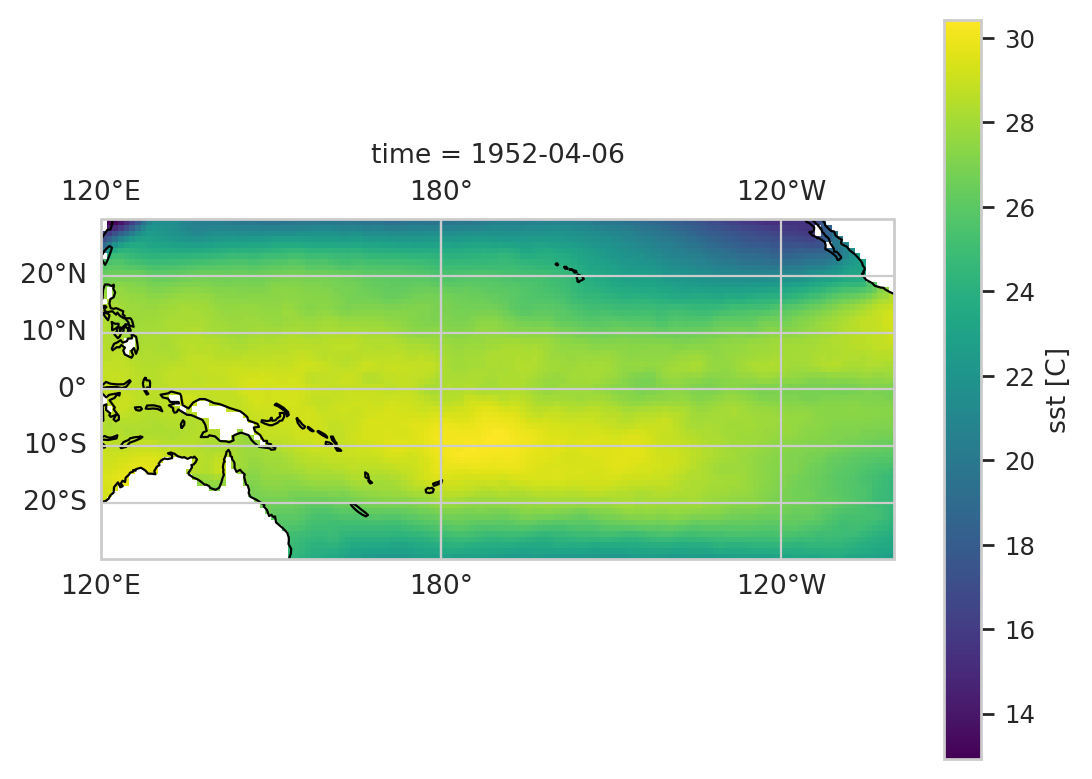

In [8]:
# define CRS's for our use case
crs0 = ccrs.PlateCarree(
    central_longitude=0
)  # for coding data, same as ccrs.PlateCarree()
crs180 = ccrs.PlateCarree(central_longitude=180)  # for plotting map in pacific area

# For all plotting, use `crs180`
fig, paco_region = plt.subplots(subplot_kw={"projection": crs180})

p = ds_obs.sst.isel(time=1000).plot(
    ax=paco_region,
    transform=crs0,  # the data's projection
)
paco_region.gridlines(crs=crs0, draw_labels=True)
paco_region.set_extent([120, 260, -30, 30], crs=crs0)
paco_region.add_feature(cfeature.COASTLINE)

## Flattening and unflattening

mrCOSTS requires data to be in the shape (`space` x `time`) but the data have the shape (`longitude` x `latitude` x `time`). We have to flatten the spatial dimension but also do some book keeping so we can un-flatten it later.

In [9]:
# Get the properties of a single snapshot, specifically the portion of the data not masked by land.
data_snapshot = ds_obs.sst.isel(time=0).values
ind_lat, ind_lon = np.where(~np.isnan(data_snapshot))
n_space = len(ind_lat)
n_time = len(ds_obs.time)

In [10]:
longitudes_ragged = ds_obs.longitude.isel(longitude=ind_lon)
latitudes_ragged = ds_obs.latitude.isel(latitude=ind_lat)

In [11]:
ds_obs["sst"] = ds_obs.sst.transpose("longitude", "latitude", "time")
data_3d = ds_obs.sst.values

data_1d = data_3d.reshape(
    ds_obs.longitude.size * ds_obs.latitude.size, ds_obs.time.size
)
nandex_1d = np.nonzero(np.isnan(data_1d))
notnandex_1d = np.nonzero(~np.isnan(data_1d))

data_to_fit = data_1d[notnandex_1d]
data_to_fit = data_to_fit.reshape(n_space, n_time)

print(data_to_fit.shape)

(7815, 1854)


# Fit mrCOSTS

The fitted model is not included since it is actually larger than the data.

## Hyperparameters

In [12]:
# Window size (in time steps)
window_lengths = np.array([16, 32, 64, 128, 256, 512, 1024])
# Step size between windows (in time steps). 10% of the window width is usually sufficient.
step_sizes = np.array([2, 3, 6, 12, 20, 50, 100])
# Rank of each decomposition levels fit.
svd_ranks = [8] * len(window_lengths)
# How many decomposition levels were performed.
num_decompositions = len(window_lengths)
# Whether to use a global svd when fitting each window.
global_svd_array = [False] * len(window_lengths)
# Other kwargs to pass to the bopdmd object.
pydmd_kwargs = None
# The name to give the model fit.
strategy = "svd-rank-{}".format(svd_ranks[0])
# This specifies that we should find the number of bands for each local decomposition level
# instead of providing the number a priori.
cluster_sweep = True

# Set this flag to True to fit the object. Once fitted, set it to False to use the previously fitted model.
fit = False

Note that if you fit with a version of PyDMD newer than 1.0, you will need to provide a few additional keywords in order to get similar result as in the PNAS paper.

- `relative_filter_length = 8`
- `kern_method = "kern"`

In [13]:
if fit:
    mrc = mrCOSTS(
        svd_rank_array=svd_ranks,
        window_length_array=window_lengths,
        step_size_array=step_sizes,
        global_svd_array=global_svd_array,
        cluster_sweep=cluster_sweep,
        transform_method="absolute",
        pydmd_kwargs=pydmd_kwargs,
    )

    mrc.fit(data_to_fit, np.atleast_2d(ts))

## I/O

Get the fitted model.

In [14]:
os.chdir(dir_results)
filename = ".".join([data_name, strategy])

if fit:
    mrc.to_netcdf(filename)

else:
    file_list = glob.glob("*" + filename + "*.nc")
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)

# Global scale separation

Perform the multi-resoltion interpolation (step 3 in the PNAS conceptual figure) in order to capture the leaked components.

In [15]:
mrc.multi_res_interp()

The Silhouette Scoring kills the kernel so we will have to tune the frequency bands "by hand". 14 bands is the objective answer in any case.

In [16]:
cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    14, transform_method="log10"
)

# Convert the centroids to periods in units of years
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi) * 365)

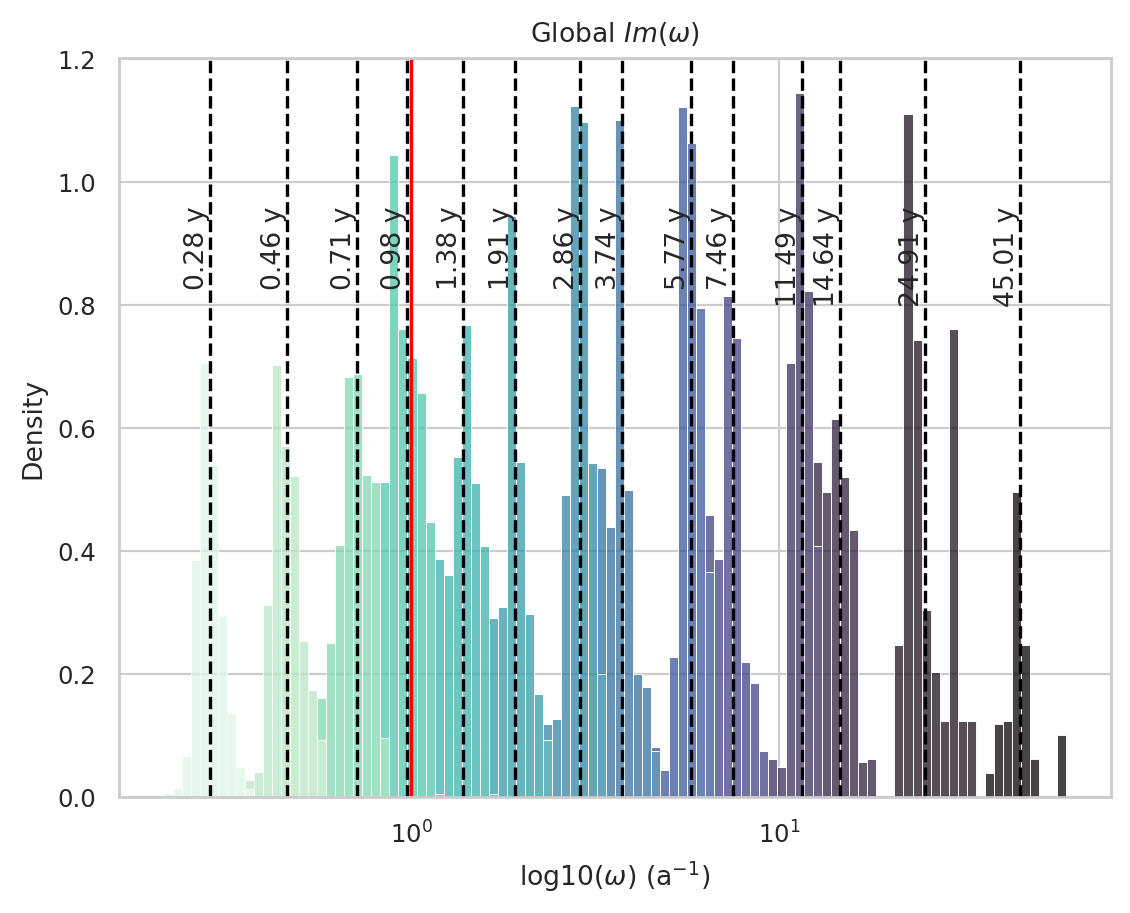

In [17]:
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)

sns.histplot(
    x=2 * np.pi / (10**omega_array) / 365,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=100,
    palette="mako",
    legend=False,
    log_scale=True,
)

ax = plt.gca()
ax.set_title("Global $Im(\omega)$")
ax.set_xlabel(r"log10($\omega$) (a$^{-1}$)")
[ax.axvline(c, color="k", ls="--") for nc, c in enumerate(cluster_centers_periods)]
y_lim_bottom, y_lim_top = ax.get_ylim()
[
    ax.text(
        c,
        y_lim_top - y_lim_top * 0.2,
        "{:4.2f} y".format(c),
        rotation="vertical",
        va="top",
        ha="right",
    )
    for c in cluster_centers_periods
]
ax.axvline(1, color="r")

# Prepare analysis

## Reconstructions

Here is the reconstruction of each band as well as the background mode. This can be expensive as we are, in essence, creating multiple different views of the data depending on the time scales of the coherent spatial patterns.

In [18]:
omega_classes_list = mrc.multi_res_deterp()
xr_sep = mrc.global_scale_reconstruction()
xr_background = mrc.get_background()

## stack/unstack

In [19]:
# Get the properties of a single snapshot, specifically the portion of the data not masked by land.
data_snapshot = ds_obs.sst.isel(time=0).values
ind_lon, ind_lat = np.where(~np.isnan(data_snapshot))
n_space = len(ind_lat)
n_time = len(ds_obs.time)

longitudes_ragged = ds_obs.longitude.isel(longitude=ind_lon)
latitudes_ragged = ds_obs.latitude.isel(latitude=ind_lat)

Unstacking the 1D spatial dimension using the xarray multiIndex framework (taken from here https://stackoverflow.com/questions/62592803/xarray-equivalent-of-np-reshape)

In [20]:
ds_background = xr.DataArray(xr_background, dims=["xy", "time"])
ds_background.coords["longitude"] = ("xy", longitudes_ragged.data)
ds_background.coords["latitude"] = ("xy", latitudes_ragged.data)
ds_background = ds_background.set_index(xy=("latitude", "longitude")).unstack("xy")

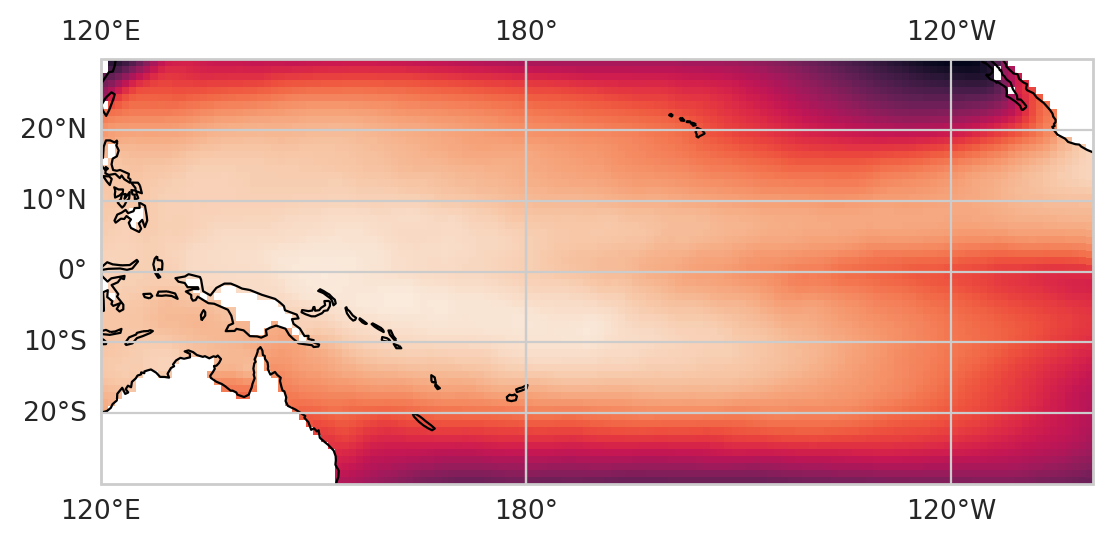

In [21]:
fig, paco_region = plt.subplots(subplot_kw={"projection": crs180})

plt.pcolormesh(
    ds_background.longitude.values,
    ds_background.latitude.values,
    ds_background.mean(dim="time").values,
    transform=crs0,  # the data's projection,
)

paco_region.gridlines(crs=crs0, draw_labels=True)
paco_region.set_extent([120, 260, -30, 30], crs=crs0)
paco_region.add_feature(cfeature.COASTLINE)

## ENSO Box

In [22]:
t1 = pd.Timestamp("2015-10-01")
t2 = pd.Timestamp("2016-02-01")
tslice_enso2015 = slice(t1, t2)
enso34_box = [-170, -120, -5, 5]
da_enso34 = ds_obs.sst.where(
    (ds_obs.latitude > enso34_box[2])
    & (ds_obs.latitude < enso34_box[3])
    & (ds_obs.longitude < enso34_box[1])
    & (ds_obs.longitude > enso34_box[0]),
    drop=True,
)

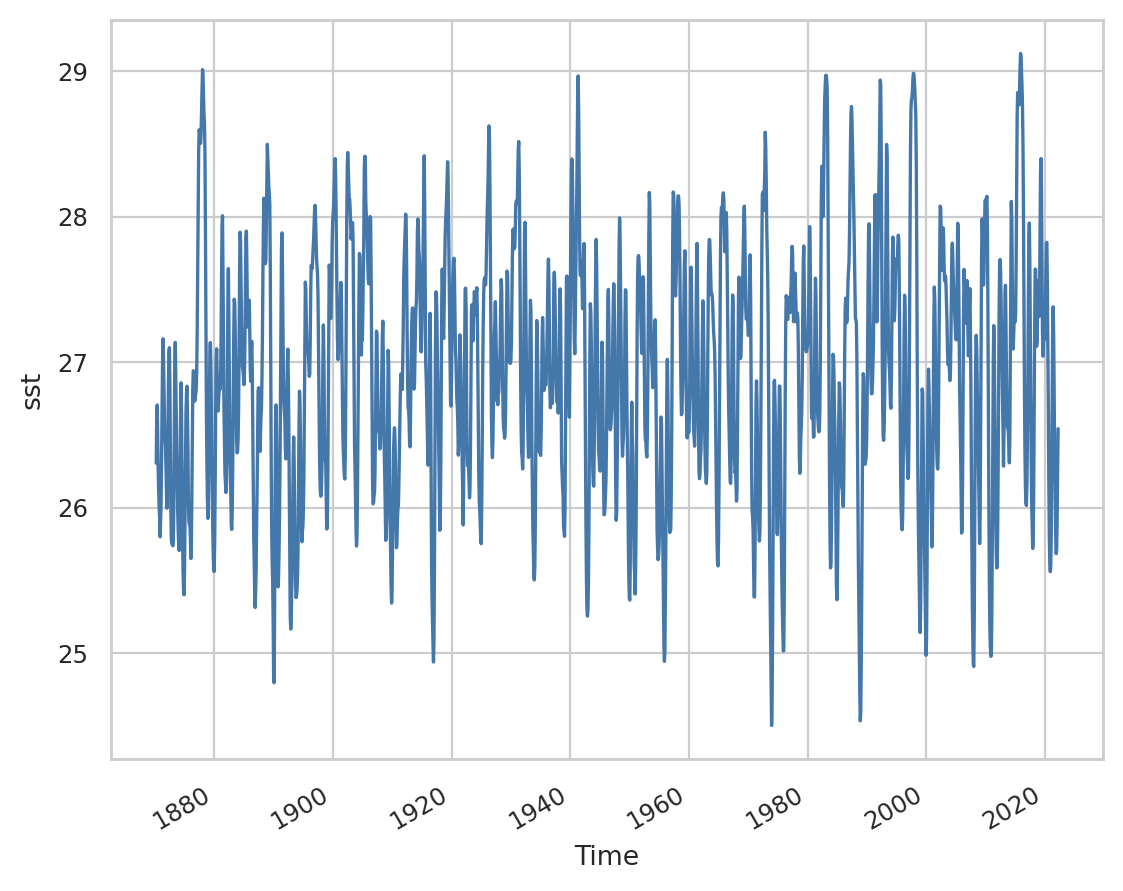

In [23]:
da_enso34.rolling(time=3, center=True).mean().mean(dim=["latitude", "longitude"]).plot()

We need to do some transformation of the box in order to plot it due to crossing the zero line of longitude for one of the projections.

In [24]:
enso34_box_crs0_transform = [
    enso34_box[0] + 180,
    enso34_box[1] + 180,
    enso34_box[2],
    enso34_box[3],
]

These are the bands that behave like ENSO in terms of spatial patterns. Note! These might be different for your own mrCOSTS fit.

In [25]:
enso_like_modes_index = [3, 5, 6, 7, 8, 9]

## Create an ONI-like value

This should match the operational definition of ENSO from the Climate Prediction Center:

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [26]:
ds_obs_enso = enso_box_extract(ds_obs.sst, enso34_box)

background_spatial_mean = ds_obs_enso.mean(dim=["latitude", "longitude"]).groupby(
    "time.month"
)

background_total_mean = ds_obs_enso.mean(dim=["latitude", "longitude"])
background_total_mean = (
    background_total_mean.sel(time=slice("1991-01-01", "2020-01-01"))
    .groupby("time.month")
    .mean()
)

background_spatial_mean = ds_obs_enso.mean(dim=["latitude", "longitude"]).groupby(
    "time.month"
)
background_anomaly = background_spatial_mean - background_total_mean

background_anomaly = background_anomaly.sel(
    time=slice(pd.Timestamp("1995-01-01"), ds_obs.time[-1])
)

background_anomaly = background_anomaly.rolling(time=3, center=True).mean()

## Plotting datasets

These are what we will use to actually plot.

In [27]:
# Observations
obs_anomaly = monthly_anomaly(ds_obs.sst)
obs_anomaly = obs_anomaly.sel(time=tslice_enso2015).mean(dim="time")
obs_anomaly = longitude_reorder(obs_anomaly)

# All modes reconstruction
xr_global = xr_sep.sum(axis=(0, 1))
ds_mrcosts_recon = xarray_unstacked(
    xr_global, ds_obs.time.values, longitudes_ragged, latitudes_ragged
)
ds_mrcosts_recon_anomaly = monthly_anomaly(ds_mrcosts_recon)
ds_mrcosts_recon_anomaly = longitude_reorder(ds_mrcosts_recon_anomaly)
ds_mrcosts_recon_anomaly = ds_mrcosts_recon_anomaly.sel(time=tslice_enso2015).mean(
    dim="time"
)

# Only ENSO-like modes
xr_global_enso = xr_sep[:, enso_like_modes_index, :, :].sum(axis=(0, 1))
ds_mrcosts_recon_enso = xarray_unstacked(
    xr_global_enso, ds_obs.time.values, longitudes_ragged, latitudes_ragged
)
ds_mrcosts_recon_enso_anomaly = monthly_anomaly(ds_mrcosts_recon_enso)
ds_mrcosts_recon_enso_anomaly = longitude_reorder(ds_mrcosts_recon_enso_anomaly)
ds_mrcosts_recon_enso_anomaly = ds_mrcosts_recon_enso_anomaly.sel(
    time=tslice_enso2015
).mean(dim="time")

# Evaluating the mrCOSTS fit

In [28]:
xr_global = xr_sep.sum(axis=(0, 1)) + xr_background
ds_global = xarray_unstacked(
    xr_global, ds_obs.time.values, longitudes_ragged, latitudes_ragged
)

In [29]:
obs = ds_obs.sst.T.values
model = ds_global.values
mrc.costs_array[0].relative_error(obs[~np.isnan(obs)], model[~np.isnan(model)])

0.11773035543410945

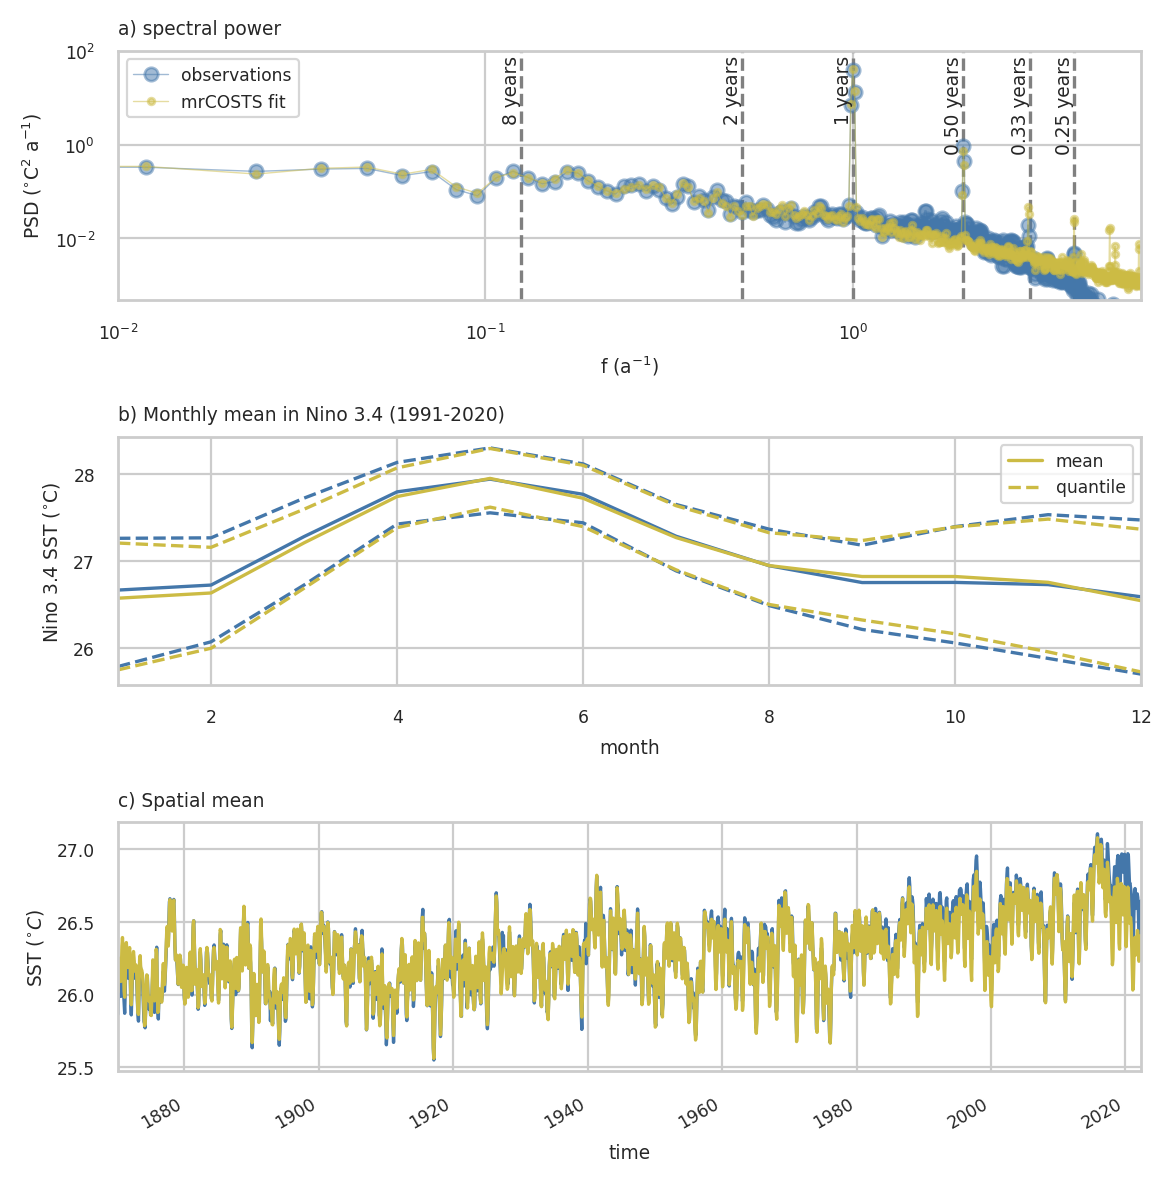

In [30]:
with (
    sns.axes_style("whitegrid"),
    sns.plotting_context("paper", font_scale=0.7),
    sns.color_palette(sns.color_palette(tol_bright_reorder)),
):

    cm = 1 / 2.54  # centimeters in inches
    fig, axes = plt.subplots(3, 1, figsize=(15 * cm, 15 * cm))

    ax = axes[0]
    fs = 365.25 / (np.diff(ts)[0])
    f, Pxx_den = signal_processing.welch(xr_global, fs, nperseg=1024, average="median")

    ax.set_ylim(5 * 10**-4, 10**2)
    ax.set_xlim(10**-2, f.max())

    y_lim_bottom, y_lim_top = ax.get_ylim()
    for t in [0.25, 0.33, 0.5, 1, 2, 8]:
        ax.axvline(1 / t, ls="--", color="0.5")
        if t >= 1:
            text = f"{t:.0f} years"
        else:
            text = f"{t:.2f} years"
        ax.text(
            1 / t,
            y_lim_top - y_lim_top * 0.2,
            text,
            rotation="vertical",
            va="top",
            ha="right",
        )

    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[0],
        lw=0.5,
        marker="o",
        alpha=0.5,
        label="observations",
    )
    f, Pxx_den = signal_processing.welch(
        data_to_fit, fs, nperseg=1024, average="median"
    )
    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[1],
        lw=0.5,
        marker=".",
        alpha=0.5,
        label="mrCOSTS fit",
    )

    ax.set_ylabel(r"PSD ($^{\circ}$C$^2$ a$^{-1}$)")
    ax.set_title("a) spectral power", loc="left")
    ax.set_xlabel("f (a$^{-1}$)")
    ax.legend()

    # Monthly means
    ax = axes[1]
    enso = enso_box_extract(
        ds_obs.sst.sel(time=slice("1991-01-01", "2020-01-01")), enso34_box
    )
    enso_monthly = enso.groupby("time.month")
    enso_monthly.mean().mean(dim=["longitude", "latitude"]).plot(
        ax=ax, color=tol_bright_reorder[0]
    )
    enso_monthly.quantile(0.75).mean(dim=["longitude", "latitude"]).plot(
        ax=ax, ls="--", color=tol_bright_reorder[0]
    )
    enso_monthly.quantile(0.25).mean(dim=["longitude", "latitude"]).plot(
        ax=ax, ls="--", color=tol_bright_reorder[0]
    )

    enso = enso_box_extract(
        ds_global.sel(time=slice("1991-01-01", "2020-01-01")), enso34_box
    )
    enso_monthly = enso.groupby("time.month")
    enso_monthly.mean().mean(dim=["longitude", "latitude"]).plot(
        ax=ax, color=tol_bright_reorder[1], label="mean"
    )
    enso_monthly.quantile(0.75).mean(dim=["longitude", "latitude"]).plot(
        ax=ax, ls="--", color=tol_bright_reorder[1]
    )
    enso_monthly.quantile(0.25).mean(dim=["longitude", "latitude"]).plot(
        ax=ax, ls="--", color=tol_bright_reorder[1], label="quantile"
    )

    ax.set_title("")
    ax.set_title("b) Monthly mean in Nino 3.4 (1991-2020)", loc="left")
    ax.set_ylabel(r"Nino 3.4 SST ($^{\circ}$C)")
    ax.set_xlim(1, 12)
    ax.legend()

    # Time series
    ax = axes[2]
    ds_obs.sst.mean(dim=["latitude", "longitude"]).plot(
        ax=ax, color=tol_bright_reorder[0]
    )
    ds_global.mean(dim=["latitude", "longitude"]).plot(
        ax=ax, color=tol_bright_reorder[1]
    )
    ax.set_ylabel("SST ($^{\circ}C$)")
    ax.set_xlim(ds_obs.time[0], ds_obs.time[-1])
    ax.set_title("")
    ax.set_title("c) Spatial mean", loc="left")

    plt.tight_layout()

    os.chdir(dir_print)
    fig.savefig("mrCOSTS-sst-eval.pdf", dpi=300, bbox_inches="tight")

# PNAS Figure

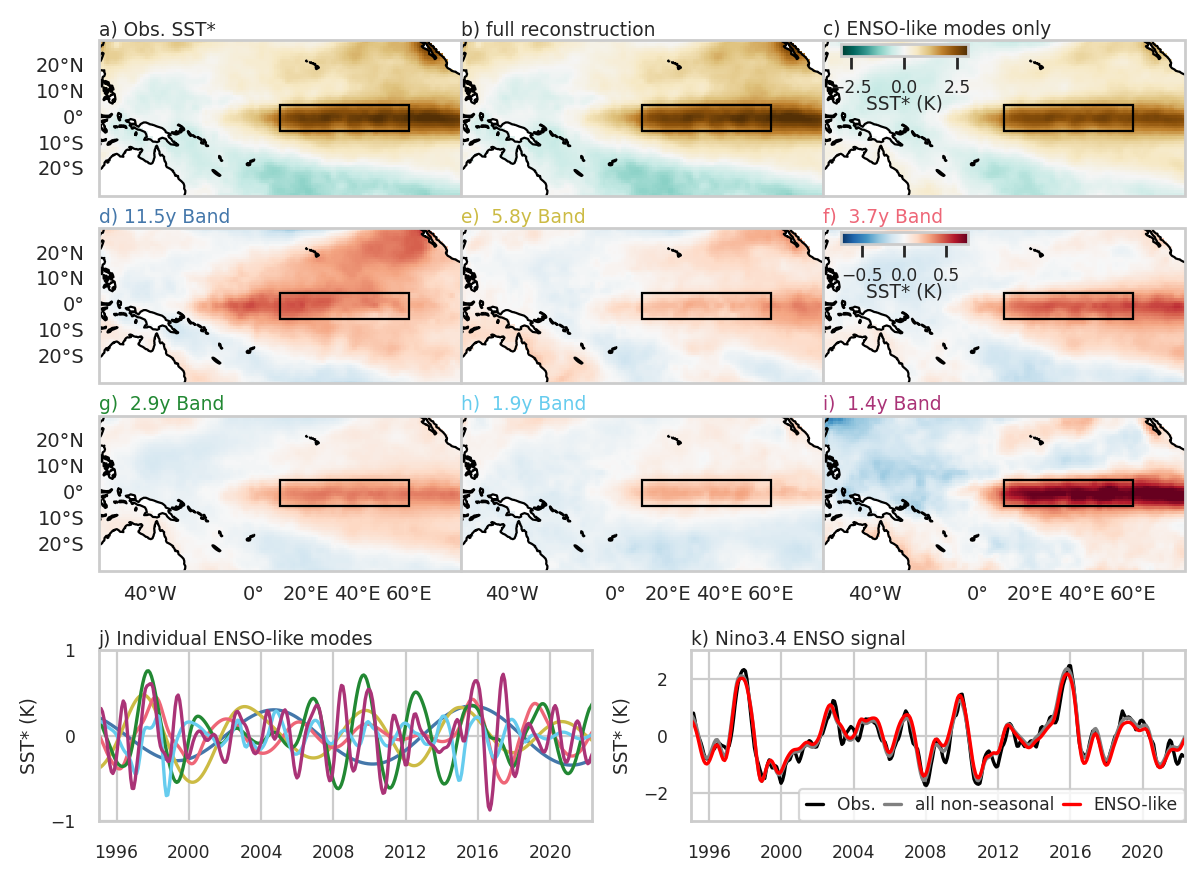

In [31]:
with (
    sns.axes_style("whitegrid"),
    sns.plotting_context("paper", font_scale=0.7),
    sns.color_palette(sns.color_palette(tol_bright_reorder)),
):
    fig = plt.figure(figsize=(17.8 * cm, 13 * cm))
    cartopy_kws = {"projection": crs180, "aspect": 1.0}
    pad = 2
    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3.2, 1])
    gs_maps = gs[0].subgridspec(3, 3, wspace=0.0, hspace=0.1)
    gs_bot = gs[1].subgridspec(1, 2, hspace=-1)

    axes_maps = []
    axes_full_recon = []
    for n in range(3):
        axes_full_recon.append(fig.add_subplot(gs_maps[0, n], **cartopy_kws))
    for nrow in range(2):
        for ncol in range(3):
            axes_maps.append(fig.add_subplot(gs_maps[nrow + 1, ncol], **cartopy_kws))

    axes_ts = []
    axes_ts.append(fig.add_subplot(gs_bot[0, 0]))
    axes_ts.append(fig.add_subplot(gs_bot[0, 1], sharex=axes_ts[0]))

    recon_sum = np.zeros(len(ds_obs.time))
    recon_sum_selected = np.zeros(len(ds_obs.time))

    ax = axes_full_recon[0]
    ax.pcolormesh(
        obs_anomaly.longitude.values,
        obs_anomaly.latitude.values,
        obs_anomaly.T.values,
        transform=crs180,  # the data's projection,
        vmin=-3,
        vmax=3,
        cmap="BrBG_r",
        rasterized=True,
    )
    ax.set_title("a) Obs. SST*", loc="left", pad=pad)
    plot_enso_box(ax, enso34_box_crs0_transform)
    add_grid_lines(ax, True)

    ax = axes_full_recon[1]
    ax.pcolormesh(
        ds_mrcosts_recon_anomaly.longitude.values,
        ds_mrcosts_recon_anomaly.latitude.values,
        ds_mrcosts_recon_anomaly.values,
        transform=crs180,  # the data's projection,
        vmin=-3,
        vmax=3,
        cmap="BrBG_r",
        rasterized=True,
    )
    ax.set_title("b) full reconstruction", loc="left", pad=pad)
    plot_enso_box(ax, enso34_box_crs0_transform)
    add_grid_lines(ax, True)

    ax = axes_full_recon[2]
    ax.pcolormesh(
        ds_mrcosts_recon_enso_anomaly.longitude.values,
        ds_mrcosts_recon_enso_anomaly.latitude.values,
        ds_mrcosts_recon_enso_anomaly.values,
        transform=crs180,  # the data's projection,
        vmin=-3,
        vmax=3,
        cmap="BrBG_r",
        rasterized=True,
    )
    ax.set_title("c) ENSO-like modes only", loc="left", pad=pad)
    plot_enso_box(ax, enso34_box_crs0_transform)
    add_grid_lines(ax, True)

    ax_counter = 0
    for ncl_center, cl_center in enumerate(cluster_centers_periods):
        # Reconstruction
        ds_global_fb_decomp = xarray_unstacked(
            xr_sep[:, ncl_center, :, :].sum(axis=0).squeeze(),
            ds_obs.time.values,
            longitudes_ragged,
            latitudes_ragged,
        )

        # Time series
        enso_component = enso_box_extract(ds_global_fb_decomp, enso34_box)
        enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])

        if cl_center > 1:
            recon_sum += enso_spatial_mean.values
        if ncl_center in enso_like_modes_index:
            recon_sum_selected += enso_spatial_mean.values
        else:
            continue

        ds_global_fb_decomp = longitude_reorder(ds_global_fb_decomp)
        ds_global_fb_decomp = ds_global_fb_decomp.sel(time=tslice_enso2015)

        ax = axes_maps[ax_counter]
        ax.pcolormesh(
            ds_global_fb_decomp.longitude.values,
            ds_global_fb_decomp.latitude.values,
            ds_global_fb_decomp.mean(dim="time").values,
            transform=crs180,  # the data's projection,
            vmin=-0.75,
            vmax=0.75,
            cmap="RdBu_r",
            rasterized=True,
        )
        plot_enso_box(ax, enso34_box_crs0_transform)
        add_grid_lines(ax, ax_counter < 3)
        ax.set_title(
            f"{alphabet[ax_counter + 3]}) {cl_center:4.1f}y Band",
            loc="left",
            color=tol_bright_reorder[ax_counter],
            pad=pad,
        )
        ax_counter += 1

        axes_ts[0].plot(
            enso_spatial_mean.time, enso_spatial_mean, label=f"{cl_center:4.1f}y"
        )

    axes_ts[0].set_ylabel("SST* (K)")
    axes_ts[0].set_xlim(pd.Timestamp("1995-01-01"), ds_obs.time[-1])
    axes_ts[0].set_ylim(-1, 1)
    axes_ts[0].set_title("j) Individual ENSO-like modes", loc="left", pad=pad)

    axes_ts[1].plot(
        background_anomaly.time,
        background_anomaly.values,
        color="k",
        label="Obs.",
    )
    axes_ts[1].plot(ds_obs.time, recon_sum, color="0.5", label="all non-seasonal")
    axes_ts[1].plot(ds_obs.time, recon_sum_selected, color="r", label="ENSO-like")
    axes_ts[1].set_xlim(pd.Timestamp("1995-01-01"), ds_obs.time[-1])
    axes_ts[1].set_ylim(-3, 3)
    axes_ts[1].legend(
        ncols=3,
        loc="lower right",
        handlelength=1,
        columnspacing=0.5,
        bbox_to_anchor=(1, 0),
        borderaxespad=0,
    )
    axes_ts[1].set_ylabel("SST* (K)")
    axes_ts[1].set_title("k) Nino3.4 ENSO signal", loc="left", pad=pad)

    # mrCOSTS band colorbar
    cmap = matplotlib.cm.RdBu_r
    norm = matplotlib.colors.Normalize(vmin=-0.75, vmax=0.75)
    cax = axes_maps[2].inset_axes([0.05, 0.9, 0.35, 0.075])

    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
        location="bottom",
    )
    cbar.set_label("SST* (K)", labelpad=-0.8)

    # SST* colorbar
    cmap = matplotlib.cm.BrBG_r
    norm = matplotlib.colors.Normalize(vmin=-3, vmax=3)
    cax = axes_full_recon[2].inset_axes([0.05, 0.9, 0.35, 0.075])

    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label("SST* (K)", labelpad=-0.8)

os.chdir(dir_print)
fig.savefig("enso-like-modes_time-series+spatial.pdf", bbox_inches="tight", dpi=300)